# 音声のコンテキストからパラメータを推測する
## 諸々Import (CPUで動くはず)

In [13]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import optimizers
from chainer import serializers

## コンテキストとパラメータの学習データを読み込む
問題設定: コンテキストの情報からパラメータを予測する

これができると何ができるのか？: 
* 形態素解析などでコンテキストを作成する
* コンテキストからパラメータを推測する←今日ここ
* パラメータから音声を作成する
* うわあああああしゃべったあああああああ
-----
メモ
* コンテキストとは、先行、当該、後続、アクセント句長、アクセント句位置、アクセント型、フレーム数の7次元からなる。
* パラメータとは、基本周波数とメルケプストラムの27次元からなる。
(本来、コンテキストに対してパラメータは可変長になるが、長さの予測は行わず、学習時に対応するフレーム数を導入することで対応関係を取ることにした。)

### 学習・評価データの形式
* [先行, 当該, 後続, アクセント句長, アクセント句位置,　アクセント型, フレーム数,　基本周波数, メルケプストラム[0...25]]
* [phoneme0, phoneme1, phoneme2, accent_len, accent_pos,　accent_type, frame_num,　f0, mcep[0...25]]

### 使ってみるときの形式
* [先行, 当該, 後続, アクセント句長, アクセント句位置,　アクセント型, フレーム数]
* [phoneme0, phoneme1, phoneme2, accent_len, accent_pos,　accent_type, frame_num]

### 使ってみた時に出てくる形式
* [基本周波数, メルケプストラム[0...25]]
* [f0, mcep[0...25]]

### datasディレクトリに諸々入れて使う

In [57]:
# 音素の変換テーブル
#　モデルの読み込みに使う。
with open('onso.pickle', 'rb') as i:
    onso_table = pickle.load(i)
# 学習データとテストデータを読み込む

try:
    contexts_train_csv = pd.read_csv('datas/train.csv', header=None) # ←ここに学習用のテキストデータを渡すと
except FileNotFoundError as e:
    print(e)

test_path = "datas/UEM_091.lab" # ←ここにUEM_091.labを渡すと UEM_091.lab.paramが生成される
try:
    contexts_test_csv = pd.read_csv(test_path, header=None) 
except FileNotFoundError as e:
    print(e)

In [58]:
train_data_len = contexts_train_csv.shape[0]
contexts_train = pd.DataFrame()
contexts_train['phoneme0'] = [onso_table[r] for r in contexts_train_csv[0]]
contexts_train['phoneme1'] = [onso_table[r] for r in contexts_train_csv[1]]
contexts_train['phoneme2'] = [onso_table[r] for r in contexts_train_csv[2]]
contexts_train['accent_len'] = contexts_train_csv[3]
contexts_train['accent_pos'] = contexts_train_csv[4]
contexts_train['accent_type'] = contexts_train_csv[5]
contexts_train['frame_num'] = contexts_train_csv[6] # 
contexts_train['f0'] = contexts_train_csv[7]
for i in range(26):
    contexts_train['mcep'+str(i)] = contexts_train_csv[8+i]

contexts_train.head()

KeyError: 'phoneme0'

In [59]:
test_data_len = contexts_test_csv.shape[0]
contexts_test = pd.DataFrame()
contexts_test['phoneme0'] = [onso_table[r] for r in contexts_test_csv[0]]
contexts_test['phoneme1'] = [onso_table[r] for r in contexts_test_csv[1]]
contexts_test['phoneme2'] = [onso_table[r] for r in contexts_test_csv[2]]
contexts_test['accent_len'] = contexts_test_csv[3]
contexts_test['accent_pos'] = contexts_test_csv[4]
contexts_test['accent_type'] = contexts_test_csv[5]
contexts_test['frame_num'] = contexts_test_csv[6]
contexts_test.head()

,phoneme0,phoneme1,phoneme2,accent_len,accent_pos,accent_type,frame_num
0,29,5,16,5,1,3,1
1,29,5,16,5,1,3,2
2,29,5,16,5,1,3,3
3,29,5,16,5,1,3,4
4,29,5,16,5,1,3,5


## ネットワークを定義する

In [60]:
# Prepare network
# n_inは入力ベクトル長
# n_outは出力ベクトル長
# 良い手段かわからないけど倍ずつ大きくして、最後27次元に落とす
# 一応毎回BatchNormalizationする。
class context2params(chainer.Chain):
    def __init__(self, n_in, n_out):
        super(context2params, self).__init__(
            l1=L.Linear(n_in, 14),
            l2=L.Linear(14, 28),
            l3=L.Linear(28, 56),
            l4=L.Linear(56, n_out),
            bn1 = L.BatchNormalization(14),
            bn2 = L.BatchNormalization(28),
            bn3 = L.BatchNormalization(56),
        )

    def __call__(self, x):
        h1 = F.relu(self.bn1(self.l1(x)))
        h2 = F.relu(self.bn2(self.l2(h1)))
        h3 = F.relu(self.bn3(self.l3(h2)))
        y = self.l4(h3)
        return y

## 学習・評価データセットを切り分ける

In [6]:
# 80%を学習に使って20％を学習の評価に使う。
contexts_train_sample = contexts_train.sample(frac=1)
N = int(len(contexts_train)*0.8)
N_test = len(contexts_train)-N
x_train = contexts_train.iloc[:N, 0:7].values.astype(np.float32)
x_test = contexts_train.iloc[N:, 0:7].values.astype(np.float32)
y_train = contexts_train.iloc[:N, 7:].values.astype(np.float32)
y_test = contexts_train.iloc[N:, 7:].values.astype(np.float32)

## ネットワークとオプティマイザを定義する

In [7]:
# ネットワーク
model = context2params(7, 27)

# 最適化
optimizer = optimizers.Adam()
optimizer.setup(model)

## 学習する

In [8]:
# 一度に勾配を求めるバッチのサイズ
batchsize = 100
# 学習を行う回数
n_epoch = 10000

for epoch in range(1, n_epoch + 1):
    # 学習
    # バッチサイズに合わせてランダムに切り出す
    perm = np.random.permutation(N)
    sum_loss = 0
    for i in range(0, N, batchsize):
        # バッチづくり
        x = np.asarray(x_train[perm[i:i + batchsize]])
        t = np.asarray(y_train[perm[i:i + batchsize]])

        # 予測
        p = model(x)
        
        # 誤差の計算
        loss = F.mean_squared_error(p, t)

        # 誤差を使って最適化
        model.cleargrads()
        loss.backward()
        optimizer.update()
        
        # 表示用
        sum_loss += float(loss.data) * len(t.data)
    train_loss = sum_loss

    # Epoch毎の評価
    sum_loss = 0
    for i in range(0, N_test, batchsize):
        #　バッチづくり
        x = np.asarray(x_test[i:i + batchsize])
        t = np.asarray(y_test[i:i + batchsize])
        
        # 予測
        p = model(x)
        
        # 誤差の計算
        loss = F.mean_squared_error(p, t)
        sum_loss += float(loss.data) * len(t.data)
    test_loss = sum_loss
    
    if epoch % 1000 == 0:
        print('epoch', epoch)
        print('train mean loss={}'.format(train_loss / N))
        print('test  mean loss={}'.format(test_loss / N_test))
        model.to_cpu()
        # 破壊的なので注意
        with open('datas/context2params_{0:07d}.pickle'.format(epoch), 'wb') as o:
            pickle.dump(model, o)

epoch 1000
train mean loss=0.00017642568855080754
test  mean loss=0.2797733247280121
epoch 2000
train mean loss=1.5507453099417035e-08
test  mean loss=0.2818864583969116
epoch 3000
train mean loss=2.5180983058252504e-13
test  mean loss=0.2818887233734131
epoch 4000
train mean loss=3.3663097808410425e-13
test  mean loss=0.28188878297805786
epoch 5000
train mean loss=8.081159005857153e-12
test  mean loss=0.2818622589111328
epoch 6000
train mean loss=2.3890828515504836e-07
test  mean loss=0.2815290093421936
epoch 7000
train mean loss=1.919779322179238e-07
test  mean loss=0.2806214392185211
epoch 8000
train mean loss=4.77437879453646e-07
test  mean loss=0.2793055474758148
epoch 9000
train mean loss=1.0830214591805998e-07
test  mean loss=0.27780264616012573
epoch 10000
train mean loss=1.914655058499193e-06
test  mean loss=0.2763797342777252


## モデルを保存しておく

In [9]:
# GPUで動かしていたらCPUに戻してくる
model.to_cpu()
# 破壊的なので注意
with open('datas/context2params.pickle', 'wb') as o:
    pickle.dump(model, o)

In [10]:
#　モデルの読み込みに使う。
with open('datas/context2params.pickle', 'rb') as i:
    model = pickle.load(i)

In [61]:
# 実際の使い方
# contexts_testからnumpy 配列として読み出してmodelに渡す
x = contexts_test.values.astype(np.float32)
# modelの返り値はVariable型になっているので.dataでnumpy.array型に戻す。
pred = pd.DataFrame(model(x).data, dtype=np.float32)

# 音声生成が使いやすい形式のファイルに書き出す
# CSV
pred.to_csv(test_path+'.param', index=False)

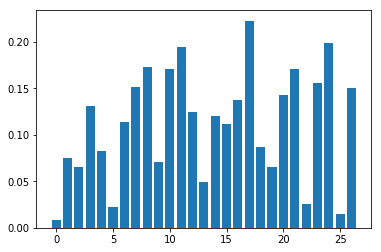

In [12]:
x = np.array([[0 for i in range(7)]], dtype=np.float32)
plt.bar(range(27), model(x).data[0])
plt.show()

## 最初は持ってないから疑似学習・評価データを作る

In [3]:
# 疑似データ生成
train_data_len = 50
np.random.seed(0)
contexts_train = pd.DataFrame()
contexts_train['phoneme0'] = np.random.randint(0,20, size = train_data_len)
contexts_train['phoneme1'] = np.random.randint(0,20, size = train_data_len)
contexts_train['phoneme2'] = np.random.randint(0,20, size = train_data_len)
contexts_train['accent_len'] = np.random.randint(0,20, size = train_data_len)
contexts_train['accent_pos'] = np.random.randint(0,20, size = train_data_len)
contexts_train['accent_type'] = np.random.randint(0,20, size = train_data_len)
contexts_train['frame_num'] = np.random.randint(0,20, size = train_data_len)
contexts_train['f0'] = np.random.rand(train_data_len)
for i in range(26):
    contexts_train['mcep'+str(i)] = np.random.rand(train_data_len)

contexts_train.head()


,phoneme0,phoneme1,phoneme2,accent_len,accent_pos,accent_type,frame_num,f0,mcep0,mcep1,...,mcep16,mcep17,mcep18,mcep19,mcep20,mcep21,mcep22,mcep23,mcep24,mcep25
0,12,8,13,14,19,12,5,0.799203,0.695625,0.959167,...,0.603323,0.263768,0.757407,0.300651,0.065121,0.516124,0.998023,0.140440,0.558283,0.740245
1,15,17,16,0,14,12,0,0.630448,0.283519,0.458139,...,0.128021,0.944626,0.203621,0.800799,0.044571,0.219861,0.533978,0.712892,0.428379,0.628314
2,0,15,7,4,3,2,8,0.874288,0.379927,0.590984,...,0.583193,0.135548,0.566312,0.548846,0.913284,0.274296,0.944203,0.830476,0.923159,0.769789
3,3,4,9,3,3,15,15,0.293020,0.181151,0.857723,...,0.002065,0.720266,0.185817,0.473326,0.305047,0.701840,0.396610,0.057909,0.105095,0.768919
4,3,9,0,13,7,7,15,0.848944,0.788546,0.457223,...,0.198911,0.925395,0.104736,0.675126,0.557987,0.030193,0.106682,0.291389,0.982574,0.856567


## 最初は持ってないから疑似テストデータを作る

In [4]:
test_data_len = 1000
contexts_test = pd.DataFrame()
contexts_test['phoneme0'] = np.random.randint(0,20, size = test_data_len)
contexts_test['phoneme1'] = np.random.randint(0,20, size = test_data_len)
contexts_test['phoneme2'] = np.random.randint(0,20, size = test_data_len)
contexts_test['accent_len'] = np.random.randint(0,20, size = test_data_len)
contexts_test['accent_pos'] = np.random.randint(0,20, size = test_data_len)
contexts_test['accent_type'] = np.random.randint(0,20, size = test_data_len)
contexts_test['frame_num'] = np.random.randint(0,20, size = test_data_len)

contexts_test.head()

,phoneme0,phoneme1,phoneme2,accent_len,accent_pos,accent_type,frame_num
0,16,9,8,3,8,10,8
1,5,1,13,9,13,1,16
2,0,8,13,17,8,8,7
3,10,7,12,19,19,9,15
4,17,12,14,17,18,12,2
